## Team 14 CSE473s project

In [1]:
import sys
from pathlib import Path

# Add the project root to sys.path dynamically
project_root = Path().resolve().parent  # notebooks/parent = project root
sys.path.append(str(project_root / "lib"))

# imports
import numpy as np
from layers import Dense
from activations import Tanh, Sigmoid, ReLU
from network import NeuralNetwork
from losses import MSE
from optimizer import SGD
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def numerical_gradient_check(model, X, y, loss_fn, epsilon=1e-5):
    # Forward pass
    y_pred = model.forward(X)
    loss = loss_fn.loss(y, y_pred)

    # get analytical gradients
    grad = loss_fn.grad(y, y_pred)
    model.backward(grad)

    # Loop 
    for layer_index, layer in enumerate(model.layers):
        params = layer.params()
   

        print(f"\nChecking layer {layer_index} ({layer.__class__.__name__})")
        
        for (param, grad_param) in params:
         
            it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])

            while not it.finished:
                idx = it.multi_index
            
                original_value = param[idx]
                
                #  L(W + epsilon)
                param[idx] = original_value + epsilon
                plus_loss = loss_fn.loss(y, model.forward(X))
                
                #  L(W - epsilon)
                param[idx] = original_value - epsilon
                minus_loss = loss_fn.loss(y, model.forward(X))
                
                # Numerical 
                numerical_grad = (plus_loss - minus_loss) / (2 * epsilon)

                param[idx] = original_value
                
                # Analytical 
                analytical_grad = grad_param[idx]
                
                # Compare
                error = abs(numerical_grad - analytical_grad)
                
                #print(f"Param {idx}: numerical={numerical_grad:.7f}, analytical={analytical_grad:.7f}, error={error:.7e}")
                
                it.iternext()


Epoch 1/1000 - loss: 1.477250
Epoch 2/1000 - loss: 1.305785
Epoch 3/1000 - loss: 1.244719
Epoch 4/1000 - loss: 1.182499
Epoch 5/1000 - loss: 1.123338
Epoch 6/1000 - loss: 1.074097
Epoch 7/1000 - loss: 1.038301
Epoch 8/1000 - loss: 1.015033
Epoch 9/1000 - loss: 1.000880
Epoch 10/1000 - loss: 0.992320
Epoch 11/1000 - loss: 0.986794
Epoch 12/1000 - loss: 0.982743
Epoch 13/1000 - loss: 0.979293
Epoch 14/1000 - loss: 0.975974
Epoch 15/1000 - loss: 0.972527
Epoch 16/1000 - loss: 0.968800
Epoch 17/1000 - loss: 0.964696
Epoch 18/1000 - loss: 0.960140
Epoch 19/1000 - loss: 0.955070
Epoch 20/1000 - loss: 0.949429
Epoch 21/1000 - loss: 0.943162
Epoch 22/1000 - loss: 0.936216
Epoch 23/1000 - loss: 0.928542
Epoch 24/1000 - loss: 0.920093
Epoch 25/1000 - loss: 0.910830
Epoch 26/1000 - loss: 0.900718
Epoch 27/1000 - loss: 0.889734
Epoch 28/1000 - loss: 0.877863
Epoch 29/1000 - loss: 0.865101
Epoch 30/1000 - loss: 0.851454
Epoch 31/1000 - loss: 0.836943
Epoch 32/1000 - loss: 0.821597
Epoch 33/1000 - l

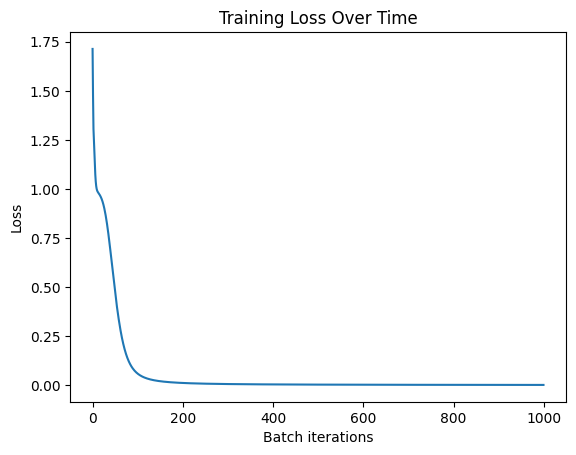

In [ ]:
# dataset
X = np.array([[-1,-1],[-1,1],[1,-1],[1,1]], dtype=float)
Y = np.array([[-1],[1],[1],[-1]], dtype=float)

# model: 2 -> 4 -> 1
layers = [
    Dense(2, 4, activation=Sigmoid()),
    Dense(4, 1, activation=Tanh())
]

model = NeuralNetwork(layers, loss_function=MSE())
opt = SGD(lr=0.5)

model.train(X, Y, opt, n_epochs=1000, batch_size=4, verbose=True)
losses = model.get_loss_history()


numerical_gradient_check(model, X, Y, MSE())
print("predictions:", model.predict(X))

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Batch iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

AutoEncoder

In [ ]:
from network import NeuralNetwork
from layers import Dense
from activations import ReLU, Sigmoid
from losses import MSE
from optimizer import SGD
import numpy as np
from tensorflow.keras.datasets import mnist

# Load MNIST
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize
x_train , x_test = x_train.astype("float32") / 255.0 , x_test.astype("float32") / 255.0


x_train , x_test = x_train.reshape(-1, 784) , x_test.reshape(-1, 784)
  

encoder_layers = [
    Dense(784, 128, activation=ReLU()),
    Dense(128, 64, activation=ReLU()),
    Dense(64, 32, activation=ReLU())
]
encoder_model = NeuralNetwork(encoder_layers, loss_function=MSE())

decoder_layers = [
    Dense(32, 64, activation=ReLU()),
    Dense(64, 128, activation=ReLU()),
    Dense(128, 784, activation=Sigmoid())
]
decoder_model = NeuralNetwork(decoder_layers, loss_function=MSE())

# Autoencoder class
class Autoencoder:
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder
        self.layers = encoder.layers + decoder.layers

    def forward(self, x):
        z = self.encoder.forward(x)
        out = self.decoder.forward(z)
        return out

    def backward(self, dL_dA):
        grad = dL_dA
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad  



ae = Autoencoder(encoder_model, decoder_model)
loss_fn = MSE()
opt = SGD(lr=0.001)

# Training loop
def train_autoencoder(ae, X, epochs=75, batch_size=256):
    n = X.shape[0]
    for epoch in range(1, epochs+1):
        idx = np.random.permutation(n)
        X = X[idx]

        epoch_loss = 0

        for i in range(0, n, batch_size):
            xb = X[i:i+batch_size]

            y_pred = ae.forward(xb)

            loss = loss_fn.loss(xb, y_pred)
            epoch_loss += loss * len(xb)

            grad = loss_fn.grad(xb, y_pred)
            ae.backward(grad)

            opt.step(ae.layers)

        print(f"Epoch {epoch}/{epochs}  Loss={epoch_loss/n:.6f}")

train_autoencoder(ae, x_train)


Epoch 1/75  Loss=0.155760
Epoch 2/75  Loss=0.071905
Epoch 3/75  Loss=0.068930
Epoch 4/75  Loss=0.066748
Epoch 5/75  Loss=0.064373
Epoch 6/75  Loss=0.061740
Epoch 7/75  Loss=0.059205
Epoch 8/75  Loss=0.056368
Epoch 9/75  Loss=0.053686
Epoch 10/75  Loss=0.051577
Epoch 11/75  Loss=0.049714
Epoch 12/75  Loss=0.048155
Epoch 13/75  Loss=0.046752
Epoch 14/75  Loss=0.045543
Epoch 15/75  Loss=0.044504
Epoch 16/75  Loss=0.043528
Epoch 17/75  Loss=0.042686
Epoch 18/75  Loss=0.041899
Epoch 19/75  Loss=0.041117
Epoch 20/75  Loss=0.040441
Epoch 21/75  Loss=0.039808
Epoch 22/75  Loss=0.039175
Epoch 23/75  Loss=0.038603
Epoch 24/75  Loss=0.037931
Epoch 25/75  Loss=0.037366
Epoch 26/75  Loss=0.036621
Epoch 27/75  Loss=0.036031
Epoch 28/75  Loss=0.035520
Epoch 29/75  Loss=0.034974
Epoch 30/75  Loss=0.034419
Epoch 31/75  Loss=0.033848
Epoch 32/75  Loss=0.033451
Epoch 33/75  Loss=0.033014
Epoch 34/75  Loss=0.032657
Epoch 35/75  Loss=0.032276
Epoch 36/75  Loss=0.031959
Epoch 37/75  Loss=0.031603
Epoch 38/7

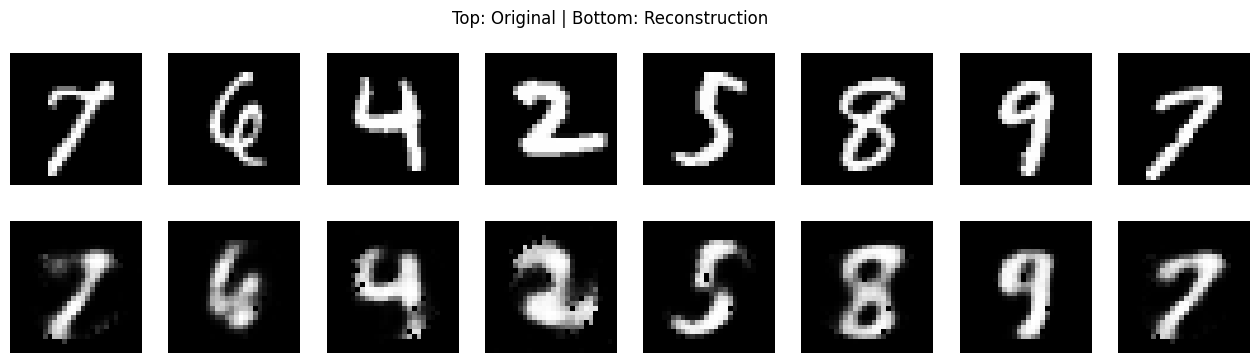

In [15]:
import matplotlib.pyplot as plt
# show some test images and their reconstructions
idxs = np.random.choice(len(x_test), 8, replace=False)
orig = x_test[idxs]
recon = ae.forward(orig)

fig, axs = plt.subplots(2,8, figsize=(16,4))
for i in range(8):
    axs[0,i].imshow(orig[i].reshape(28,28), cmap='gray')
    axs[0,i].axis('off')
    axs[1,i].imshow(recon[i].reshape(28,28), cmap='gray')
    axs[1,i].axis('off')
plt.suptitle('Top: Original | Bottom: Reconstruction')
plt.show()


latent feature extraction


In [16]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist

# -------------------------------------------------------------
# 1. Load MNIST (TensorFlow)
# -------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten and normalize
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 28*28).astype("float32") / 255.0

print("MNIST loaded:", x_train.shape, x_test.shape)



print("Encoding latent space...")
latent_train = encoder_model.forward(x_train)
latent_test  = encoder_model.forward(x_test)

print("Latent shapes:", latent_train.shape, latent_test.shape)

# -------------------------------------------------------------
# 3. Train SVM on the latent vectors
# -------------------------------------------------------------
clf = SVC(kernel="rbf", gamma="scale")
clf.fit(latent_train, y_train)

# -------------------------------------------------------------
# 4. Test accuracy
# -------------------------------------------------------------
y_pred = clf.predict(latent_test)

acc = accuracy_score(y_test, y_pred)
print("\nSVM Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


MNIST loaded: (60000, 784) (10000, 784)
Encoding latent space...
Latent shapes: (60000, 32) (10000, 32)

SVM Accuracy: 0.9403

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.92      0.94      0.93      1032
           3       0.93      0.93      0.93      1010
           4       0.92      0.94      0.93       982
           5       0.91      0.92      0.92       892
           6       0.95      0.96      0.96       958
           7       0.94      0.92      0.93      1028
           8       0.94      0.91      0.92       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion Matrix:
[[ 963    0    4    1    0    4    5    1    2    0]
 [   0 1122    3   